In [14]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
import cv2

In [7]:
def resize_image_and_mask(image, mask, size=(255, 255)):
    """Resize both image and mask to the same size"""
    image_resized = cv2.resize(image, size)
    mask_resized = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)
    return image_resized, mask_resized

In [8]:
def normalize_image(image):
    """Normalize image pixels to range [0,1]"""
    return image.astype(np.float32) / 255.0

In [9]:
def augment_image_and_mask(image, mask):
    """Apply augmentation: flip, rotate, stretch"""
    h, w = image.shape[:2]

    # Random horizontal flip
    if np.random.rand() > 0.5:
        image = cv2.flip(image, 1)
        mask = cv2.flip(mask, 1)

    # Random rotation (-20 to 20 degrees)
    angle = np.random.uniform(-20, 20)
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    image = cv2.warpAffine(image, M, (w, h))
    mask = cv2.warpAffine(mask, M, (w, h), flags=cv2.INTER_NEAREST)

    # Random stretching (scaling X or Y axis)
    scale_x = np.random.uniform(0.8, 1.2)
    scale_y = np.random.uniform(0.8, 1.2)
    M_stretch = np.array([[scale_x, 0, 0], [0, scale_y, 0]], dtype=np.float32)
    image = cv2.warpAffine(image, M_stretch, (w, h))
    mask = cv2.warpAffine(mask, M_stretch, (w, h), flags=cv2.INTER_NEAREST)

    return image, mask

In [10]:
annFile = 'annotations/instances_val2017.json'
img_path = 'val2017/'

In [11]:
coco = COCO(annFile)

loading annotations into memory...
Done (t=0.63s)
creating index...
index created!


In [12]:
catIds = coco.getCatIds(catNms=['person'])
imgIds = coco.getImgIds(catIds=catIds)

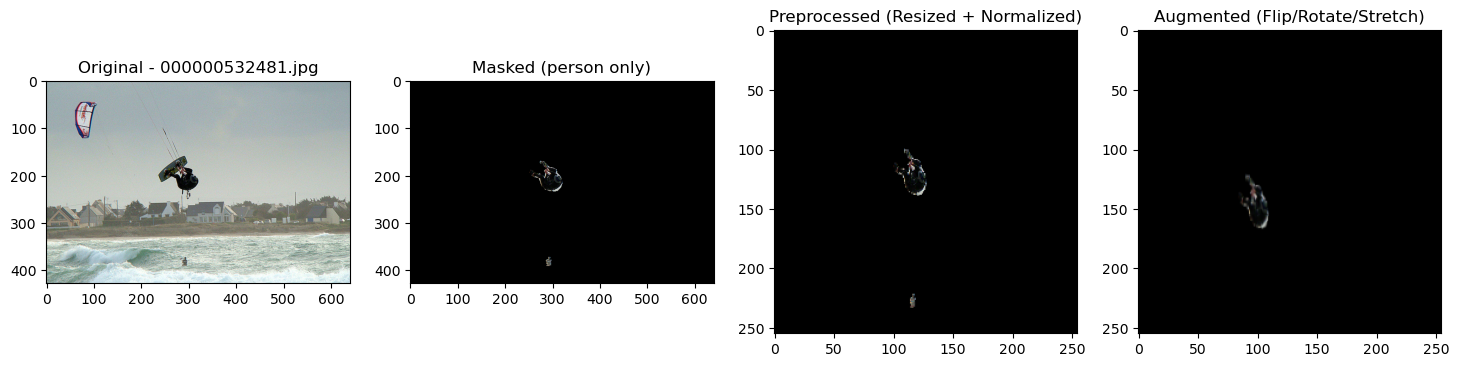

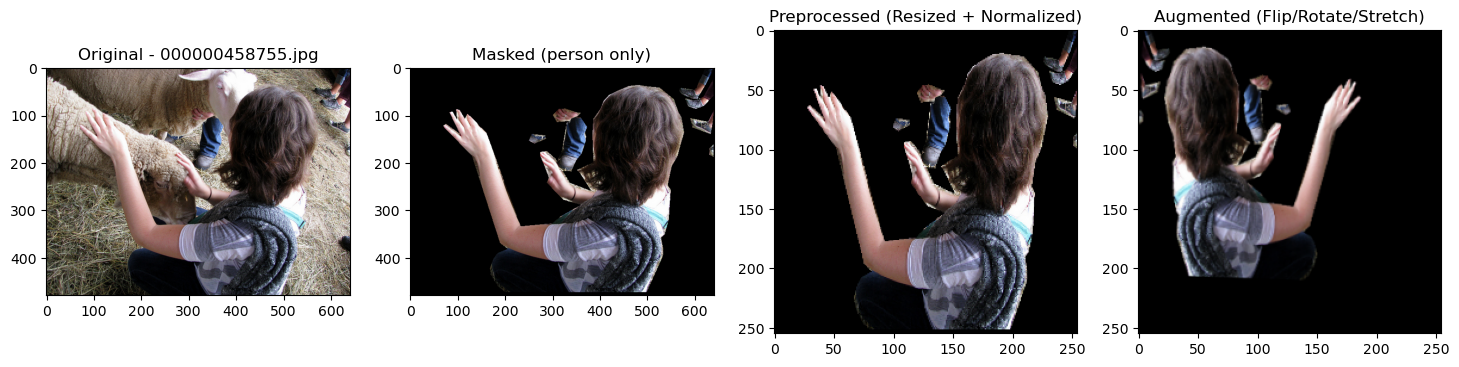

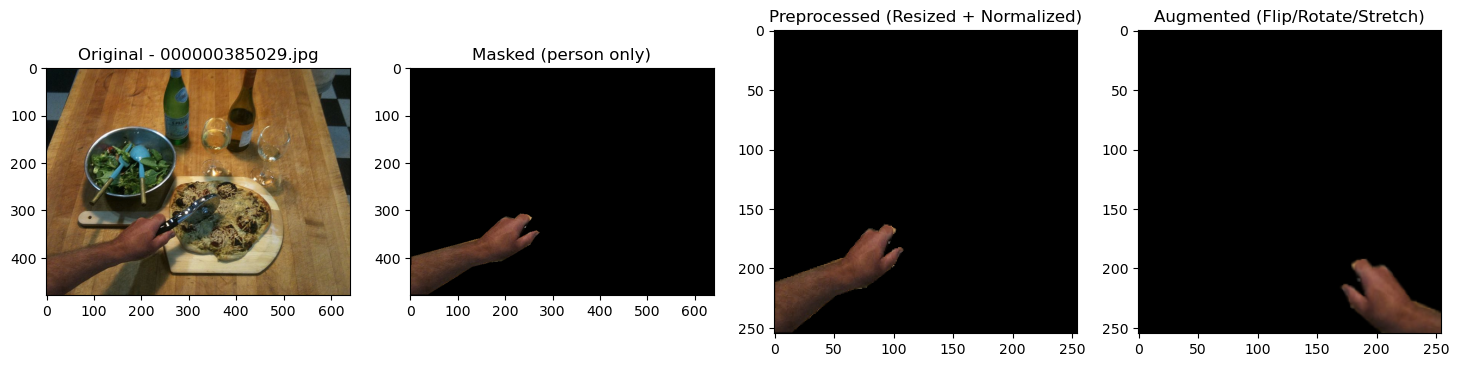

In [26]:
for i, imgId in enumerate(imgIds[:3]):  # take 3 images for demo
    img_info = coco.loadImgs(imgId)[0]
    I = io.imread(img_path + img_info['file_name'])

    annIds = coco.getAnnIds(imgIds=imgId, catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)

    # --------------------------
    # Create Mask (person only)
    # --------------------------
    mask = np.zeros((I.shape[0], I.shape[1]), dtype=np.uint8)
    for ann in anns:
        rle = coco.annToRLE(ann)
        m = maskUtils.decode(rle)
        mask = np.maximum(mask, m)

    # Apply mask to image (keep only person region)
    masked_img = I * mask[:, :, np.newaxis]

    # --------------------------
    # Preprocessing + Augmentation
    # --------------------------
    I_resized, mask_resized = resize_image_and_mask(masked_img, mask, (255, 255))
    I_norm = normalize_image(I_resized)

    I_aug, mask_aug = augment_image_and_mask(I_resized, mask_resized)

    # --------------------------
    # Show Results
    # --------------------------
    plt.figure(figsize=(18, 8))

    plt.subplot(1, 4, 1)
    plt.imshow(I)
    plt.title(f"Original - {img_info['file_name']}")

    plt.subplot(1, 4, 2)
    plt.imshow(masked_img)
    plt.title("Masked (person only)")

    plt.subplot(1, 4, 3)
    plt.imshow(I_norm)
    plt.title("Preprocessed (Resized + Normalized)")

    plt.subplot(1, 4, 4)
    plt.imshow(I_aug)
    plt.title("Augmented (Flip/Rotate/Stretch)")

    plt.show()